In [1]:
import numpy as np

import torch
import torch.utils.data

import datasets
import metaimage
import nnet
import voxgrid
import display

%load_ext autoreload
%autoreload 2

Train: 900


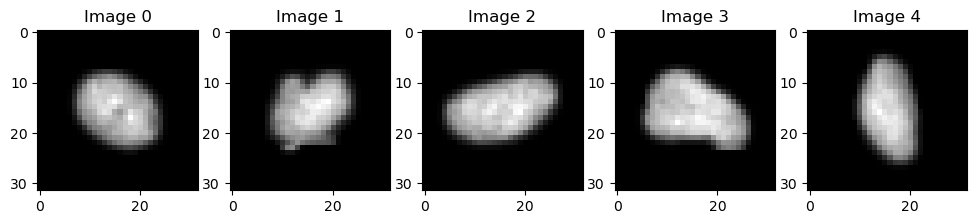

In [2]:
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)

BATCH_SIZE = 100

IMG_FOLDER = "images/bbbc039/images/"

train_imgs, val_imgs = datasets.split_folder(IMG_FOLDER, 0.9, max_images=1000)

train_auto_dataset = datasets.CachedImages(IMG_FOLDER, train_imgs, train=True, size=IMAGE_SIZE, grayscale=True)
val_auto_dataset = datasets.CachedImages(IMG_FOLDER, val_imgs, size=IMAGE_SIZE, grayscale=True)

print(f"Train: {len(train_auto_dataset)}")

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            (f"Image {i}", metaimage.Mask(train_auto_dataset[i][0])) for i in range(5)
        ]
    ],
    figsize=(12, 12),
)
display.show()

In [3]:
LATENT_SIZE = 128
BASE_CHANNELS = 8
DISCRIMINATOR_CHANNELS = 4
BACKGROUND_CHANNELS = 8
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.1
GENERATOR_DROPOUT = 0.1

DEVICE = torch.device("cuda:0")

def create_nnets():
    discriminator = torch.nn.Sequential(
        nnet.blocks.conv.BasicConvBlock(
            in_channels=1,
            out_channels=DISCRIMINATOR_CHANNELS,
            kernel_size=7,
            stride=2,
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0]//2, IMAGE_SIZE[1]//2),
            out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0]//4, 2, 2),
            layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
                stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            total_layers=1,
        ),
        nnet.blocks.conv.ConvToLinear(
            (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0]//4, 2, 2),
            out_dim=1,
            activation=torch.nn.Sigmoid,
        ),
    )

    voxel_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.resnet.create_resnet_3d_factory(
                activation=ACTIVATION,
                dropout=nnet.modules.AlwaysDropout(GENERATOR_DROPOUT, device=DEVICE),
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                activation=ACTIVATION,
                dropout=nnet.modules.AlwaysDropout(GENERATOR_DROPOUT, device=DEVICE),
            ),
            total_layers=1,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=2,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.VoxGridAlphaAdjust()
    )

    mask_generator = nnet.generators.MaskGenerator(
        model_gen = voxel_generator,
        device = DEVICE,
        # background_gen=background_generator,
    )

    return voxel_generator, mask_generator, discriminator

vox_gen, mask_gen, discriminator = create_nnets()

gan_trainer = nnet.training.GANTrainer(
    mask_gen,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/bbbc039_img_gan"
bookmark_interval = 25

In [7]:
gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    100,
    path=model_path,
    noise=0.2,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 350/350 | val loss (gen/dis): 0.9025/3.1060 | train loss: 1.11(99)/0.87(86): 100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


Model models/bbbc039_img_gan_250.pt is loaded from epoch 250 , loss 0.8586
Model models/bbbc039_img_gan_275.pt is loaded from epoch 275 , loss 0.7869
Model models/bbbc039_img_gan_300.pt is loaded from epoch 300 , loss 0.8725
Model models/bbbc039_img_gan_325.pt is loaded from epoch 325 , loss 0.9538
Model models/bbbc039_img_gan_350.pt is loaded from epoch 350 , loss 0.9025


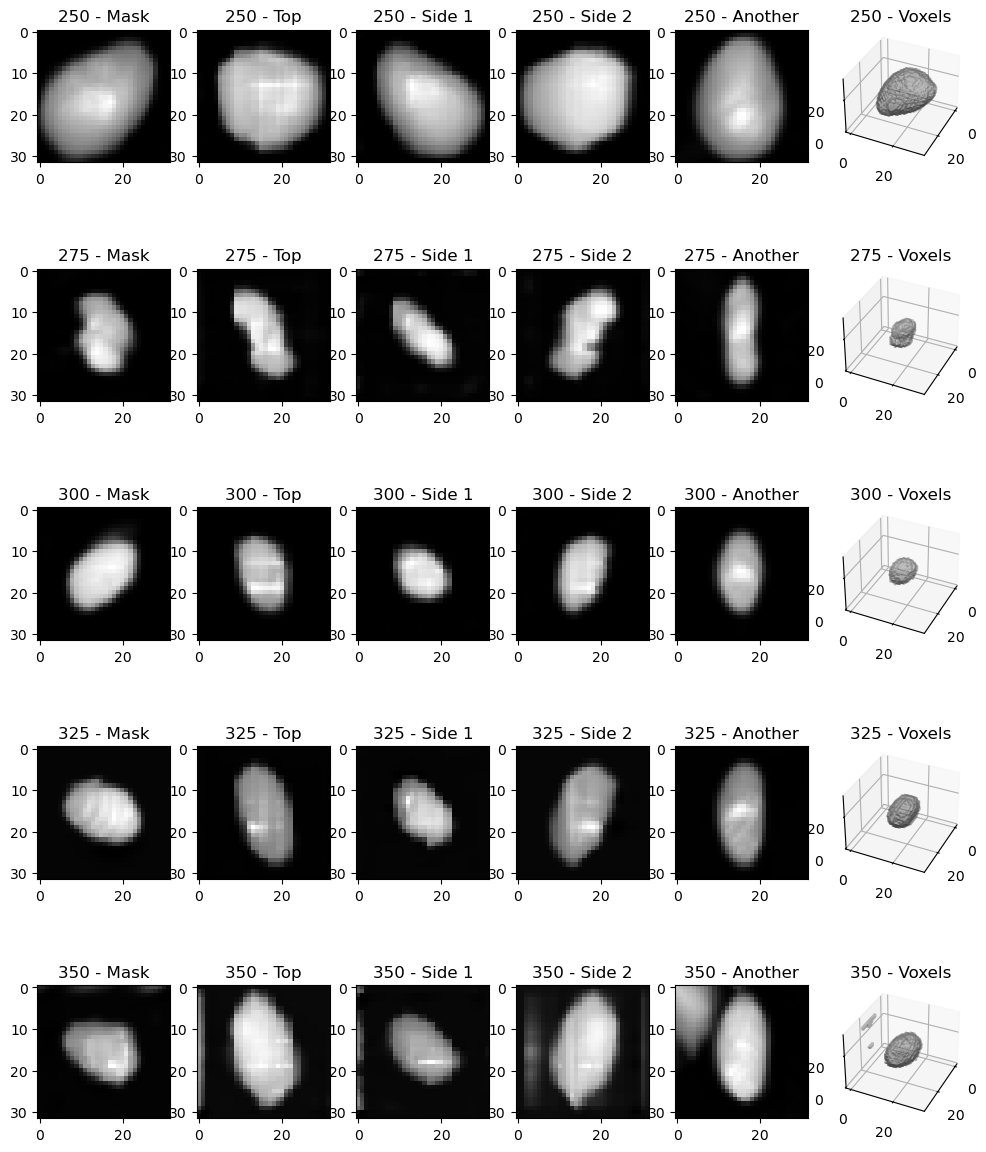

In [8]:
START_MODEL = 250
END_MODEL = 350

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

vox_gen.eval()
mask_gen.eval()
mask_gen.to(DEVICE)

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer.load_state(f"{model_path}_{model_n}.pt")
    
    mask_out = mask_gen(gen_input)[0]

    mask = metaimage.Mask(
        mask_out, title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * len(plot_grid)))
display.show()

Model models/bbbc039_img_gan_275.pt is loaded from epoch 275 , loss 0.7869


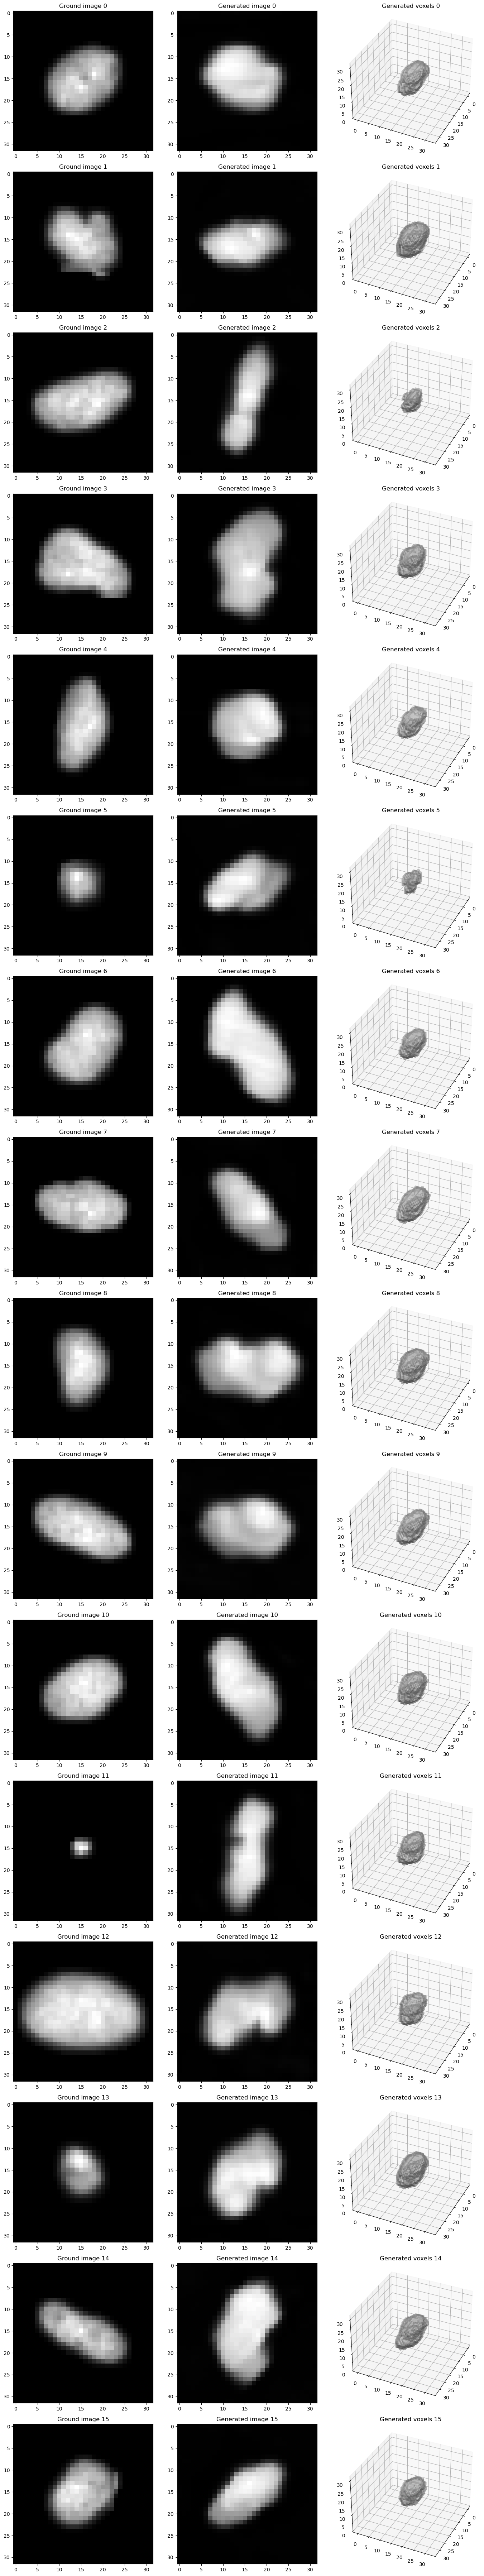

In [33]:
MODEL = 275
N_SAMPLES = 16

gan_trainer.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(N_SAMPLES+1, LATENT_SIZE))).cuda()

plot_grid = []

masks = mask_gen(gen_input)[:N_SAMPLES]
voxels = vox_gen(gen_input)[:N_SAMPLES]

for i in range(N_SAMPLES):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask(masks[i], title=f"Generated image {i}")
    ground_mask = train_auto_dataset[i][1]
    ground_mask = metaimage.Mask(ground_mask, title=f"Ground image {i}")

    plot_grid.append([ground_mask, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(14, N_SAMPLES*4.5))
display.show()